# Lecture 7b - Clustering

Clustering is used in a wide variety of applications of including:

* For customer segmentation: you can cluster you customers based on their purchases
* For data analysis: when you have a new dataset it is often useful to analyze clusters separately
* As a dimensionality reduction  technique
* For anomaly detection
* For semi-supervised learning
* For information retrival
* For image segmentation

There is no universal definition of what cluster is. It really depends on the context.

Different algorithms compute different kind of clusters. 

For instance, some algorithms look for instances centered around a particular point, called a centroid.

Other look for continuos regios of densely packed instances: these clusters can take on any shape.

Some algorithms are hierarchical, it means they look for clusters of clusters.

In this lecture we are going to focus on two of the most popular algorithms: K-Means and DBSCAN.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Clustering

## Introduction – Classification _vs_ Clustering

In [4]:
from sklearn.datasets import load_iris

In [6]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_plot


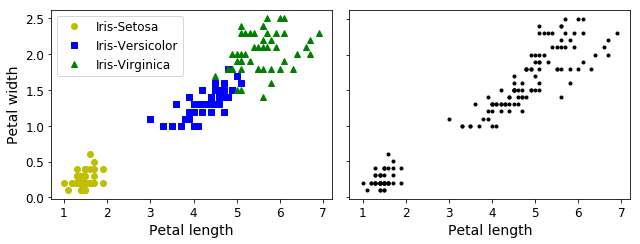

In [7]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris-Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris-Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris-Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

## K-Means

Let's start by generating some blobs:

In [10]:
from sklearn.datasets import make_blobs

In [9]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [11]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's plot them:

In [12]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


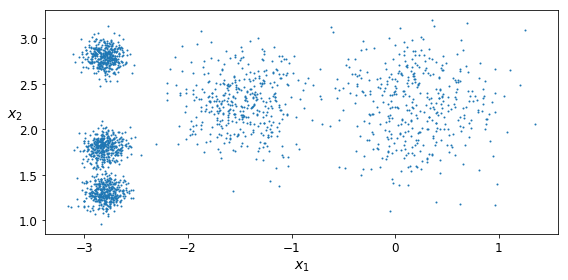

In [13]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

Let's train a K-Means clusterer on this dataset. 
It will try to find each blob's center and assign each instance to the closest blob:

In [15]:
from sklearn.cluster import KMeans

Note that you have to specify the number of clusters k that the algorithm must find. 

In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy. We will discuss this shortly.

Each instance was assigned to one of the 5 clusters. 

In the context of clustering, an instance’s label is the index of the cluster that this instance gets assigned to by the algorithm: this is not to be confused with the class labels

In [19]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [20]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

You can also look at the computed centroids

In [21]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [22]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

Of course, we can predict the labels of new instances:

In [23]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

### Decision Boundaries
If you plot the cluster’s decision boundaries, you get a Voronoi tessellation (see Figure 9-3, where each centroid is represented with an X):

In [24]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


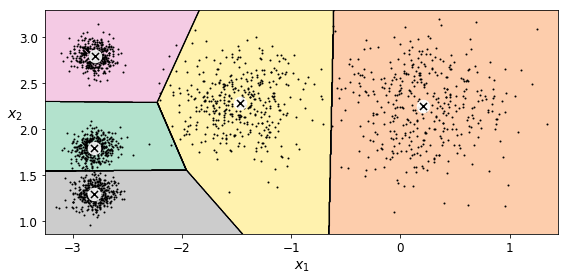

In [25]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

### Hard Clustering _vs_ Soft Clustering

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [26]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [27]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [31]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
# clustering solution ater one step
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)

# clustering solution ater two steps
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
    n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
    tol=0.0001, verbose=0)

And let's plot this:

Saving figure kmeans_algorithm_plot


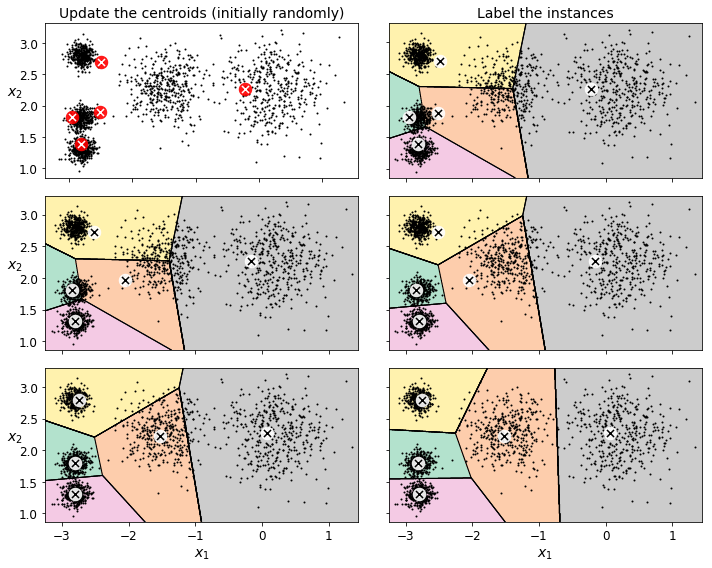

In [32]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

### K-Means Variability
Unfortunately, although the algorithm is guaranteed to converge, it may not converge to the right solution (i.e., it may converge to a local optimum): this depends on the centroid initialization.

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [35]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


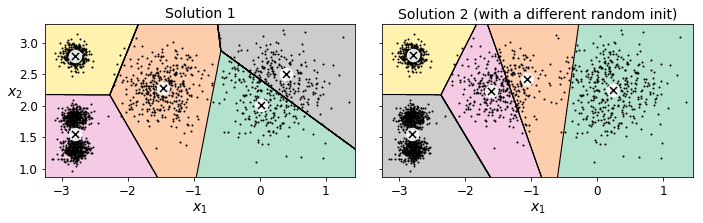

In [36]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

### Centroid Initialization Methods
If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

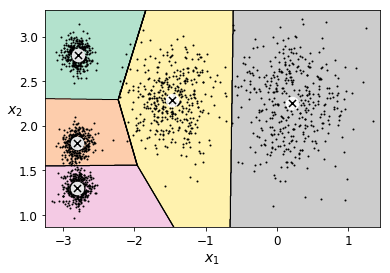

In [41]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)
plot_decision_boundaries(kmeans, X)

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution. This is controlled by the n_init hyperparameter: by default, it is equal to 10, which means that the whole algorithm described earlier actually runs 10 times when you call fit(), and Scikit-Learn keeps the best solution.

**Question**
But how exactly does it know which solution is the best?


Well of course it uses a performance metric! It is called the model’s **inertia**: this is the mean squared distance between each instance and its closest centroid.


If you are curious, a model’s inertia is accessible via the ``inertia_`` instance variable:

In [42]:
kmeans.inertia_

211.5985372581684

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [43]:
# your code here

X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

(2000, 5)


211.59853725816845

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_great is better_" rule.

In [32]:
kmeans.score(X)

-211.59853725816856

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [33]:
kmeans_rnd_init1.inertia_

223.29108572819035

In [34]:
kmeans_rnd_init2.inertia_

237.46249169442845

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [44]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)
kmeans_rnd_10_inits.score(X)

-211.59853725816845

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

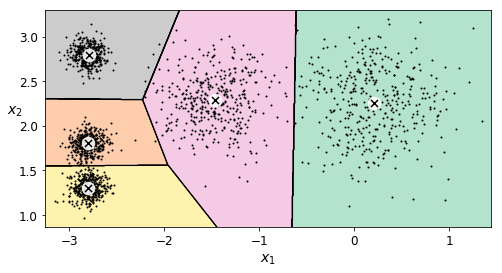

In [36]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [37]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [48]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans_pp = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)

kmeans.fit(X)
kmeans_pp.fit(X)
print("Good init: ",kmeans.inertia_)
print("K-means++: ", kmeans_pp.inertia_)


Good init:  211.5985372581684
K-means++:  211.5985372581684


### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality
(given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) 
and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. 

Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [49]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

73.3 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [50]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

90.4 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Finding the optimal number of clusters

So far, we have set the number of clusters k to 5 because it was obvious by looking at the data that this is the correct number of clusters. But in general, it will not be so easy to know how to set k, and the result might be quite bad if you set it to the wrong value. For example, as you can see from the figures below that setting k to 3 or 8 results in fairly.

Saving figure bad_n_clusters_diagram


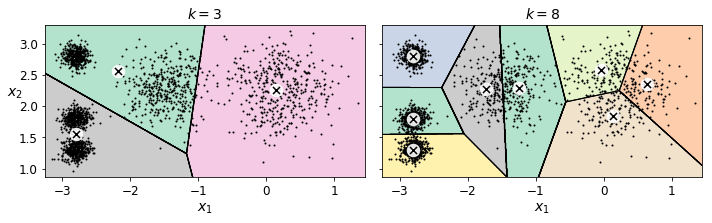

In [57]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

You might be thinking that we could just pick the model with the lowest inertia, right? 
Unfortunately, it is not that simple. The inertia for k=3 is 653.2,
which is much higher than for k=5 (which was 211.6), but with k=8, the inertia is just 119.1.



In [58]:
kmeans_k3.inertia_

653.2167190021553

In [59]:
kmeans_k8.inertia_

119.11983416102879

The inertia is not a good performance metric when trying to choose k since it keeps getting lower as we increase k. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. Let’s plot the inertia as a function of k and analyze the resulting curve.

In [55]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


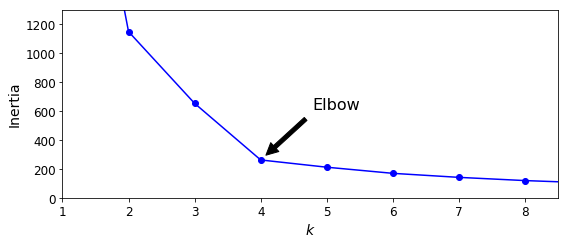

In [56]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

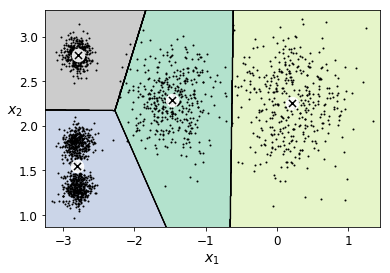

In [62]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another, more reasonable, approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the samples in the dataset. 

An instance's silhouette coefficient is equal to 

$$silhouette(x) = \frac{(b - a)}{\max(a, b)}$$

where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), 

and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). 

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [57]:
from sklearn.metrics import silhouette_score

In [58]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [59]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


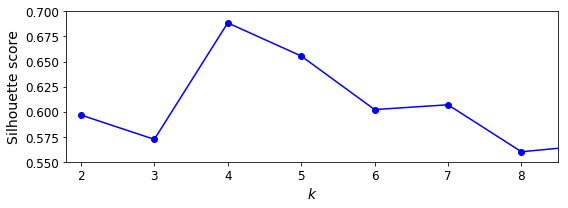

In [60]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

Saving figure silhouette_analysis_plot


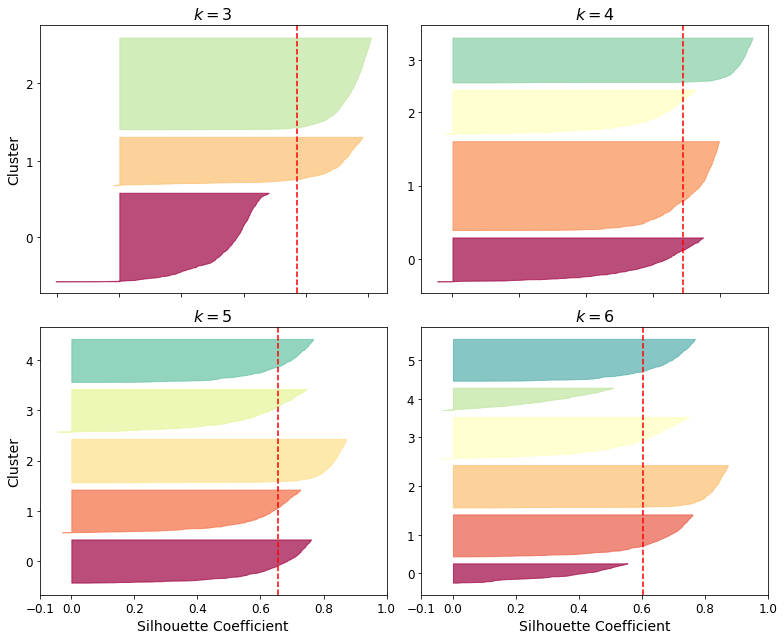

In [61]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. We can see that when k=3 and when k=6, we get bad clusters. But when k=4 or k=5, the clusters look pretty good – most instances extend beyond the dashed line, to the right and closer to 1.0. When k=4, the cluster at index 1 (the third from the top), is rather big, while when k=5, all clusters have similar sizes, so even though the overall silhouette score from k=4 is slightly greater than for k=5, it seems like a good idea to use k=5 to get clusters of similar sizes.

### Limits of K-Means

Despite its many merits, most notably being fast and scalable, K-Means is not perfect.

As we saw, it is necessary to run the algorithm several times to avoid sub-optimal solutions, plus you need to specify the number of clusters, which can be quite a hassle. Moreover, K-Means does not behave very well when the clusters have varying sizes, different densities, or non-spherical shapes. 

For example, the following figure shows how K-Means clusters a dataset containing three ellipsoidal clusters of different dimensions, densities and orientations:

In [62]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

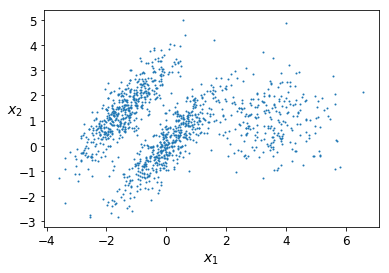

In [63]:
plot_clusters(X)

In [67]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_pp = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)

kmeans_good.fit(X)
kmeans_pp.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Saving figure bad_kmeans_plot


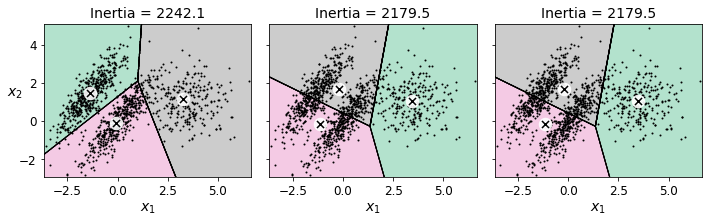

In [68]:
plt.figure(figsize=(10, 3.2))

plt.subplot(131)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(132)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.subplot(133)
plot_decision_boundaries(kmeans_pp, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_pp.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

As you can see, neither of these solutions are any good. The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it to the cluster on the right. The solution on the right is just terrible, even though its inertia is lower. So depending on the data, different clustering algorithms may perform better.

### Using clustering for image segmentation

Image segmentation is the task of partitioning an image into multiple segments. In semantic segmentation, all pixels that are part of the same object type get assigned to the same segment. For example, in a self-driving car’s vision system, all pixels that are part of a pedestrian’s image might be assigned to the “pedestrian” segment (there would just be one segment containing all the pedestrians). In instance segmentation, all pixels that are part of the same individual object are assigned to the same segment. In this case there would be a different segment for each pedestrian. The state of the art in semantic or instance segmentation today is achieved using complex architectures based on convolutional neural networks (see Chapter 14). Here, we are going to do something much simpler: color segmentation. We will simply assign pixels to the same segment if they have a similar color. In some applications, this may be sufficient, for example if you want to analyze satellite images to measure how much total forest area there is in a region, color segmentation may be just fine.

First, let’s load the image (see the upper left image in Figure 9-12) using Matplotlib’s imread() function:

In [72]:
from matplotlib.image import imread
image = imread(os.path.join("images","unsupervised_learning","ladybug.png"))
image.shape

(533, 800, 3)

The image is represented as a 3D array: the first dimension’s size is the height, the second is the width, and the third is the number of color channels, in this case red, green and blue (RGB). In other words, for each pixel there is a 3D vector containing the intensities of red, green and blue, each between 0.0 and 1.0 (or between 0 and 255 if you use imageio.imread()). Some images may have less channels, such as grayscale images (one channel), or more channels, such as images with an additional alpha channel for transparency, or satellite images which often contain channels for many light frequencies (e.g., infrared). The following code reshapes the array to get a long list of RGB colors, then it clusters these colors using K-Means. For example, it may identify a color cluster for all shades of green. Next, for each color (e.g., dark green), it looks for the mean color of the pixel’s color cluster. For example, all shades of green may be replaced with the same light green color (assuming the mean color of the green cluster is light green). Finally it reshapes this long list of colors to get the same shape as the original image. And we’re done!

In [73]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

This outputs the image shown in the upper right of Figure 9-12. You can experiment with various numbers of clusters, as shown in the figure. When you use less than 8 clusters, notice that the ladybug’s flashy red color
ails to get a cluster of its own: it gets merged with colors from the environment. This is due to the fact that the ladybug is quite small, much smaller than the rest of the image, so even though its color is flashy, K-Means fails to dedicate a cluster to it: as mentioned earlier, K-Means prefers clusters of similar sizes.

In [74]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


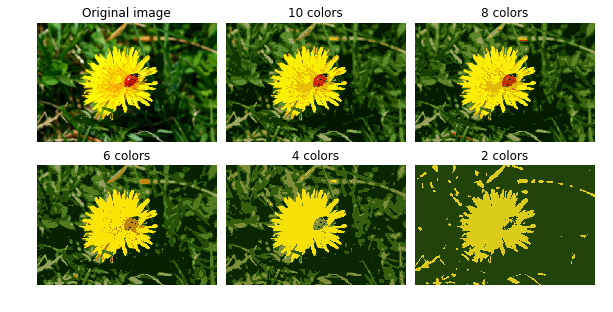

In [75]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Using Clustering for Preprocessing

Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing step before a supervised learning algorithm. For example, let’s tackle the digits dataset which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9. First, let’s load the dataset:

In [76]:
from sklearn.datasets import load_digits

In [77]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train)

/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Let's evaluate its accuracy on the test set

In [82]:
log_reg.score(X_test, y_test)

0.9644444444444444

Okay, that's our baseline: 96.7% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [83]:
from sklearn.pipeline import Pipeline

In [84]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)),
])
pipeline.fit(X_train, y_train)

/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile

Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [85]:
pipeline.score(X_test, y_test)

0.98

In [86]:
1 - (1 - 0.9822222) / (1 - 0.9666666)

0.4666670666658673

How about that? We almost divided the error rate by a factor of 2! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [87]:
from sklearn.model_selection import GridSearchCV

In [88]:
# your code here
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] ............................. kmeans__n_clusters=6, total=   0.2s
[CV] kmeans__n_clusters=6 ............................................
[CV] ............................. kmeans__n_clusters=6, total=   0.3s
<<6070 more lines>>


  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic

[CV] ............................ kmeans__n_clusters=99, total=   1.0s


/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, ...penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kmeans__n_clusters': range(2, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Let’s look at best value for k, and the performance of the resulting pipeline:


In [89]:
grid_clf.best_params_

{'kmeans__n_clusters': 87}

In [90]:
grid_clf.score(X_test, y_test)

0.9777777777777777

The performance is slightly improved when $k=90$, so 90 it is.

### Clustering for Semi-supervised Learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances. Let’s train a logistic regression model on a sample of 50 labeled instances from the digits dataset:

In [91]:
n_labeled = 50

In [92]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

Let's check the score on the test set

In [92]:
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [93]:
k = 50

In [94]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

Saving figure representative_images_diagram


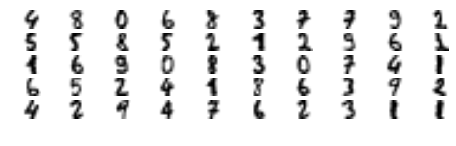

In [95]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [96]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [97]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9222222222222223

Wow! We jumped from 82.7% accuracy to 92.4%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [98]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [99]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train_propagated)

/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs faile

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [100]:
log_reg.score(X_test, y_test)

0.9222222222222223

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 20th percentile closest to the centroid:

In [101]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [102]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [103]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
log_reg.score(X_test, y_test)

0.9377777777777778

Nice! With just 50 labeled instances (just 5 examples per class on average!), we got 94.2% performance, which is pretty close to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.7%).

This is because the propagated labels are actually pretty good: their accuracy is very close to 99%:

In [105]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

You could now do a few iterations of _active learning_:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

## DBSCAN

This algorithm defines clusters as continuous regions of high density. 

It is actually quite simple:

1. For each instance, the algorithm counts how many instances are located within a small distance $\epsilon$ (epsilon) from it. 
   This region is called the instance’s $\epsilon$-neighborhood.
2. If an instance has at least ``min_samples`` instances in its $\epsilon$-neighborhood (including itself), then it is considered a core instance. 
   In other words, core instances are those    that are located in dense regions.
3. All instances in the neighborhood of a core instance belong to the same cluster. This may include other core instances, therefore a long sequence of neighboring core 
   instances forms a single cluster.
   
   Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

This algorithm works well if all the clusters are dense enough, and they are well separated by low-density regions.

The DBSCAN class in Scikit-Learn is as simple to use as you might expect. Let’s test it on the moons dataset.

In [1]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

The labels of all the instances are now available in the ``labels_`` instance variable:

In [110]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

Notice that some instances have a cluster index equal to -1: this means that they are considered as anomalies by the algorithm. 

The indices of the core instances are available in the ``core_sample_indices_`` instance variable, 
and the core instances themselves are available in the ``components_`` instance variable:

In [114]:
print(len(dbscan.core_sample_indices_))

print(dbscan.core_sample_indices_[:10])

print(dbscan.components_[:3])

print(np.unique(dbscan.labels_))

As you can see, it identified quite a lot of anomalies, plus 7 different clusters. 

How disappointing! Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, 
we get the clustering on the right, which looks perfect. Let’s continue with this model.

In [2]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [3]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [4]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


NameError: name 'plt' is not defined

In [ ]:
dbscan = dbscan2

Somewhat surprisingly, the DBSCAN class does not have a ``predict()`` method, although it has a ``fit_predict()`` method. 

In other words, it cannot predict which cluster a new instance belongs to. 

The rationale for this decision is that several classification algorithms could make sense here, 
and it is easy enough to train one, for example a ``KNeighborsClassifier``

In [120]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

Now, given a few new instances, we can predict which cluster they most likely belong to, and even estimate a probability for each cluster. Note that we only trained them on the core instances, but we could also have chosen to train them on all the instances, or all but the anomalies: this choice depends on the final task.

In [121]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [122]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

The decision boundary is represented on the followin figure (the crosses represent the 4 instances in X_new). 

Notice that since there is no anomaly in the KNN’s training set, the classifier always chooses a cluster, even when that cluster is far away. However, it is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies. To do this, we can use the kneighbors() method of the KNeighborsClassifier: given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices, each with k columns):

Saving figure cluster_classification_diagram


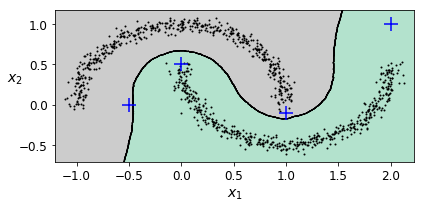

In [123]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [124]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

In short, DBSCAN is a very simple yet powerful algorithm, capable of identifying any number of clusters, of any shape, it is robust to outliers, and it has just two hyperparameters (eps and min_samples). However, if the density varies significantly across the clusters, it can be impossible for it to capture all the clusters properly. Moreover, its computational complexity is roughly O(m log m), making it pretty close to linear with regards to the number of instances. However, Scikit-Learn’s implementation can require up to O(m2) memory if eps is large.

## Other Clustering Algorithms

Scikit-Learn implements several more clustering algorithms that you should take a look at. We cannot cover them all in detail here, but here is a brief overview:

### Spectral Clustering

Spectral clustering: this algorithm takes a similarity matrix between the instances and creates a low-dimensional embedding from it (i.e., it reduces its dimensionality), then it uses another clustering algorithm in this low-dimensional space (Scikit-Learn’s implementation uses K-Means). Spectral clustering can capture complex cluster structures, and it can also be used to cut graphs (e.g., to identify clusters of friends on a social network), however it does not scale well to large number of instances, and it does not behave well when the clusters have very different sizes.

In [125]:
from sklearn.cluster import SpectralClustering

In [126]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=100, kernel_params=None,
          n_clusters=2, n_init=10, n_jobs=None, n_neighbors=10,
          random_state=42)

In [127]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1, kernel_params=None,
          n_clusters=2, n_init=10, n_jobs=None, n_neighbors=10,
          random_state=42)

In [128]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [129]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

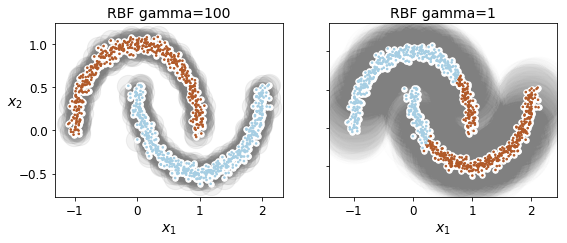

In [130]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Agglomerative Clustering

Agglomerative clustering: a hierarchy of clusters is built from the bottom up. Think of many tiny bubbles floating on water and gradually attaching to each other until there’s just one big group of bubbles. Similarly, at each iteration agglomerative clustering connects the nearest pair of clusters (starting with individual instances). If you draw a tree with a branch for every pair of clusters that merged, you get a binary tree of clusters, where the leaves are the individual instances. This approach scales very well to large numbers of instances or clusters, it can capture clusters of various shapes, it produces a flexible and informative cluster tree instead of forcing you to choose a particular cluster scale, and it can be used with any pairwise distance. It can scale nicely to large numbers of instances if you provide a connectivity matrix. This is a sparse m by m matrix that indicates which pairs of instances are neighbors (e.g., returned by sklearn.neighbors.kneighbors_graph()). Without a connectivity matrix, the algorithm does not scale well to large datasets.

In [131]:
from sklearn.cluster import AgglomerativeClustering

In [132]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [133]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [134]:
learned_parameters(agg)

['children_', 'labels_', 'n_components_', 'n_leaves_']

In [135]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

---
Honorable Mention
---
* Birch: this algorithm was designed specifically for very large datasets, and it can be faster than batch K-Means, with similar results, as long as the number of features is not too large (<20). It builds a tree structure during training containing just enough information to quickly assign each new instance to a cluster, without having to store all the instances in the tree: this allows it to use limited memory, while handle huge datasets.

* Affinity propagation: this algorithm uses a voting system, where instances vote for similar instances to be their representatives, and once the algorithm converges, each representative and its voters form a cluster. This algorithm can detect any number of clusters of different sizes. Unfortunately, this algorithm has a computational complexity of O(m2), so it is not suited for large datasets

* Mean-shift: this algorithm starts by placing a circle centered on each instance, then for each circle it computes the mean of all the instances located within it, and it shifts the circle so that it is centered on the mean. Next, it iterates this mean-shift step until all the circles stop moving (i.e., until each of them is centered on the mean of the instances it contains). This algorithm shifts the circles in the direction of higher density, until each of them has found a local density maximum. Finally, all the instances whose circles have settled in the same place (or close enough) are assigned to the same cluster. This has some of the same features as DBSCAN, in particular it can find any number of clusters of any shape, it has just one hyperparameter (the radius of the circles, called the bandwidth) and it relies on local density estimation. However, it tends to chop clusters into pieces when they have internal density variations.

* Birch: this algorithm was designed specifically for very large datasets, and it can be faster than batch K-Means, with similar results, as long as the number of features is not too large (<20). It builds a tree structure during training containing just enough information to quickly assign each new instance to a cluster, without having to store all the instances in the tree: this allows it to use limited memory, while handle huge datasets.